<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/ds-project-thematic-maps/blob/main/code/Choropleth_map_using_Uber_H3_average_PM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install h3
!pip install h3==3.6.1

In [ ]:
!pip3 install geojson

In [ ]:
!pip install folium
!pip install uszipcode
!pip install geopandas
%pip install pygeohash

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pygeohash as gh

from pandas import Series, DataFrame
import plotly.graph_objs as go
from IPython.display import Image
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
from folium import plugins
from datetime import datetime
import datetime as dt
import json
from scipy import stats

import os

In [4]:
import h3

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [5]:
points_web_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_web_PATH='https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'


In [6]:
air =  gpd.read_file(points_web_PATH)
air.describe()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
count,169999,169999,169999,169999,169999,169999,169999,169999,169999,169999,...,169999,169999,169999,169999,169999,169999,169999,169999,169999,169999
unique,3,168349,14346,9335,1337,356,120,44,53,49,...,3,2,2,2,2,2,3,334,786,35047
top,NYCP2_CS01A,1632978774,40.81316,-73.889748,2,0,0,0,0,0,...,0,0,0,0,0,0,0,17,60.3,4.348237524
freq,137455,2,615,547,3247,36949,81790,122786,110099,120546,...,169958,169972,169979,169989,169988,169991,169976,1819,496,6000


In [ ]:
air.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25,geometry
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,23.7,57.3,4.508813264,None
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,0,0,23.7,57.8,5.462420278,None
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,0,0,23.7,57.8,5.154880855,None
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,0,0,23.6,57.6,4.508813264,None
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,0,0,23.6,57.5,5.539503334,None


Transform epoch time series to datetime

In [8]:
air['time'] = air['time'].astype('int').astype("datetime64[s]")
air.head(2)

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
0,NYCP2_CS01A,2021-09-10 12:35:04,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,0,23.7,57.3,4.508813264
1,NYCP2_CS01A,2021-09-10 12:35:08,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,0,0,0,23.7,57.8,5.462420278


break it down into smaller components

In [9]:
time = pd.to_datetime(air['time'])

air['day'] = time.dt.day
air['hour'] = time.dt.hour
air['month'] = time.dt.month

air[0:5]

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin20,bin21,bin22,bin23,temperature,humidity,pm25,day,hour,month
0,NYCP2_CS01A,2021-09-10 12:35:04,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,23.7,57.3,4.508813264,10,12,9
1,NYCP2_CS01A,2021-09-10 12:35:08,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,23.7,57.8,5.462420278,10,12,9
2,NYCP2_CS01A,2021-09-10 12:35:13,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,23.7,57.8,5.154880855,10,12,9
3,NYCP2_CS01A,2021-09-10 12:35:18,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,23.6,57.6,4.508813264,10,12,9
4,NYCP2_CS01A,2021-09-10 12:35:23,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,23.6,57.5,5.539503334,10,12,9


In [ ]:
#Remove values will missing coordinates

In [10]:
air = air[(air['latitude'] != 0 ) & (air['longitude']!=0 )]

In [11]:
sampling_fraction = 0.6
geohash_precision = 6
#%timeit
#air['geohash']=air.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=geohash_precision), axis=1)

In [12]:
air[0:5]

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin20,bin21,bin22,bin23,temperature,humidity,pm25,day,hour,month
0,NYCP2_CS01A,2021-09-10 12:35:04,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,23.7,57.3,4.508813264,10,12,9
1,NYCP2_CS01A,2021-09-10 12:35:08,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,23.7,57.8,5.462420278,10,12,9
2,NYCP2_CS01A,2021-09-10 12:35:13,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,23.7,57.8,5.154880855,10,12,9
3,NYCP2_CS01A,2021-09-10 12:35:18,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,23.6,57.6,4.508813264,10,12,9
4,NYCP2_CS01A,2021-09-10 12:35:23,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,23.6,57.5,5.539503334,10,12,9


In [13]:
numeric_columns = (air
                   .select_dtypes(include=np.number)
                   .columns
                   .to_list())
air[numeric_columns].head()

,day,hour,month
0,10,12,9
1,10,12,9
2,10,12,9
3,10,12,9
4,10,12,9


In [14]:
air.shape

(169999, 34)

Shorten table into the three columns of concern

In [15]:
#air.dropna(inplace=True)

#air.shape
air2 = (air[['pm25','latitude','longitude']])

air2.shape

(169999, 3)

set H3 resolution value to what matches the requirements the best

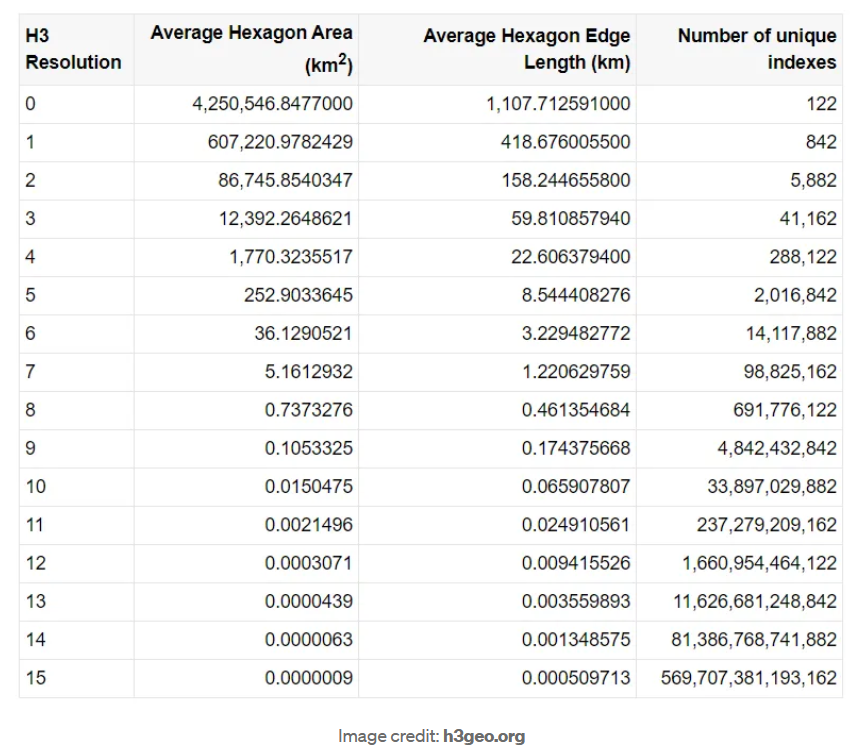

In [16]:
H3_res = 10

def geo_2_h3(row):
  return h3.geo_to_h3(lat=float(row.latitude),lng=float(row.longitude),resolution = H3_res)

air2['h3_cell'] = air2.apply(geo_2_h3,axis=1)

<ipython-input-16-94b73c5859fa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air2['h3_cell'] = air2.apply(geo_2_h3,axis=1)


utilize geo_2_h3 function to sort the coordinates into h3 cells and add the cell id to a new column to the table

In [17]:
air2.head()

,pm25,latitude,longitude,h3_cell
0,4.508813264,40.847672,-73.869316,8a2a1001320ffff
1,5.462420278,40.847668,-73.869316,8a2a1001320ffff
2,5.154880855,40.847649,-73.869362,8a2a1001320ffff
3,4.508813264,40.847649,-73.869362,8a2a1001320ffff
4,5.539503334,40.847649,-73.869362,8a2a1001320ffff


further summarize the table into the data of concer and the h3 cell only

In [22]:
air2_error = (air2[['pm25','h3_cell']])
air2_error.head()

,pm25,h3_cell
0,4.508813264,8a2a1001320ffff
1,5.462420278,8a2a1001320ffff
2,5.154880855,8a2a1001320ffff
3,4.508813264,8a2a1001320ffff
4,5.539503334,8a2a1001320ffff


group all pm25 values belonging to the same h3 cell into a single row

In [31]:
air2_error.shape[0]

169999

In [35]:
air2 = air2_error

In [32]:
#air2 = air2_error[~air2_error['pm25'].apply(lambda x: isinstance(x, str))]


In [39]:
#air2 = air2[air2['pm25'] != '3.447159572']

In [42]:
air2['pm25'] = pd.to_numeric(air2['pm25'], errors='coerce')


In [43]:
air2.shape[0]

169973

In [44]:
air2_g = air2[['h3_cell','pm25']].groupby(['h3_cell'], as_index=False).agg({'h3_cell': 'first', 'pm25':'mean'})


In [45]:
air2_g.shape[0]

1296

In [46]:
air2_g.head(2)

,h3_cell,pm25
0,8a2a10002697fff,5.091709
1,8a2a100111b7fff,3.498658


In [47]:
# Convert the 'pm25' column to numeric type; set non-numeric values to NaN
air2["pm25"] = pd.to_numeric(air2["pm25"], errors="coerce")

# Drop rows containing NaN in the 'pm25' column
air2.dropna(subset=["pm25"], inplace=True)

In [48]:
air2_g.sort_values('pm25',ascending=False)

,h3_cell,pm25
1193,8a2a100f66cffff,12.318045
1083,8a2a100f2c4ffff,11.910532
1201,8a2a100f6757fff,11.881132
1190,8a2a100f6627fff,11.853053
1085,8a2a100f2c5ffff,11.678037
...,...,...
493,8a2a100a9307fff,2.095261
179,8a2a1001801ffff,2.082990
178,8a2a10018017fff,2.065786
751,8a2a100ab1a7fff,2.063135


create the mapping information from the h3 cell values to create the hexagon geometry for each cell on the world map

In [49]:
from shapely.geometry import Polygon
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['h3_cell'], True)
  return Polygon(points)
#Apply function into our dataframe
air2_g['geometry'] = (air2_g
                                .apply(add_geometry,axis=1))

air2_g.head()

,h3_cell,pm25,geometry
0,8a2a10002697fff,5.091709,POLYGON ((-73.82585487645801 40.85301523229938...
1,8a2a100111b7fff,3.498658,POLYGON ((-73.84422832444736 40.86124098172965...
2,8a2a1001192ffff,3.842270,POLYGON ((-73.82966929282296 40.86539650876212...
3,8a2a10011937fff,3.650415,POLYGON ((-73.8315605955595 40.866860786419814...
4,8a2a10011947fff,3.653968,POLYGON ((-73.82897561191432 40.86314523222157...


transform the new table into a geojson object

In [50]:
from geojson import Feature, Point, FeatureCollection, Polygon

def hexagons_dataframe_to_geojson(df_hex, hex_id_field,geometry_field, value_field,file_output = None):

    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)

    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)

    else :
      return feat_collection

geojson_obj = (hexagons_dataframe_to_geojson
                (air2_g,
                 hex_id_field='h3_cell',
                 value_field='pm25',
                 geometry_field='geometry'))

In [53]:
import plotly.express as px


In [54]:
air2_g

,h3_cell,pm25,geometry
0,8a2a10002697fff,5.091709,POLYGON ((-73.82585487645801 40.85301523229938...
1,8a2a100111b7fff,3.498658,POLYGON ((-73.84422832444736 40.86124098172965...
2,8a2a1001192ffff,3.842270,POLYGON ((-73.82966929282296 40.86539650876212...
3,8a2a10011937fff,3.650415,POLYGON ((-73.8315605955595 40.866860786419814...
4,8a2a10011947fff,3.653968,POLYGON ((-73.82897561191432 40.86314523222157...
...,...,...,...
1291,8a2a1018b64ffff,4.789486,POLYGON ((-73.89449562053818 40.90268149949197...
1292,8a2a1018b657fff,3.251334,"POLYGON ((-73.8963905510363 40.90414546208198,..."
1293,8a2a1018b65ffff,3.878422,"POLYGON ((-73.8960417945417 40.90301943902458,..."
1294,8a2a1018b66ffff,4.788642,POLYGON ((-73.89329814708152 40.90346956258759...


use plotty express to display the results.
(zoom on New York to view the map)
The map shows the count of <2.5 micro meter particle matters found in NYC

In [57]:
air2_g.shape[0]

1296

In [61]:
fig = (px.choropleth_mapbox(
                    air2_g,
                    geojson=geojson_obj,
                    locations='h3_cell',
                    color='pm25',
                    color_continuous_scale="Viridis",
                    range_color=(0,air2_g['pm25'].mean()           ),                  mapbox_style='carto-positron',
                    zoom=11,
                    center = {"lat": 40.776676, "lon": -73.971321},
                    opacity=0.7,
                    labels={'pm25':'average PM25'}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<font color='blue' size=8> Instructor comments</font>  by [Dr. Isam Al Jawarneh](https://isamaljawarneh.github.io/)

- <font color='green' size=8> RMSE, RMSD, MAE, MAPE, R-Square </font>
  - to calculate any of these metrics to test the accuracy, you need to group data into two distributions, one for the original and one for the simplified, then calculate those metrics as distances between distributions.

  Here, I am coding an example for RMSE, MAPE, Pearson, KL Divergence and other metrics for the count and Top-N respectively. That is to say, how much is the difference in count of `taxi` trips between the original data and the sampled data for each neighborhood in New York City (NYC).

  TODO:
  - you need to apply the same methods for the distribution of the averages, by how much the distribution of averages across neighborhoods in city-wide diverge for the simplified version data as compared to the original data
  - You need to apply the same methods to data sampled using `H3` and Google's `S2`, similar to what has been done with the geohash in the attached example notebook titled `stratified_sampling_RMSE_mobility_NYC.ipynb`

<font color = 'blue'></font>